## **Perplexity**

In [12]:
import numpy as np
import pandas as pd
import torch
import os
from transformers import AutoModelForCausalLM, AutoTokenizer
from sklearn.model_selection import train_test_split
import seaborn as sns
from tqdm import tqdm

In [4]:
print(os.getcwd())
os.chdir('../..')
print(os.getcwd())

/home/onyxia/ml-for-nlp/analysis/notebooks
/home/onyxia/ml-for-nlp


In [7]:
from src.libs.preprocess_dataframe_train_test import load_all_datasets

In [8]:
data = load_all_datasets()

### Global X, y
X_train = data["X_train"]
y_train = data["y_train"]
X_test = data["X_test"]
y_test = data["y_test"]

### Global dataframes
df_train = data["df_train"]
df_test = data["df_test"]

### By type: poetry, essay, story (train)
df_train_poetry = data["df_train_poetry"]
df_train_essay = data["df_train_essay"]
df_train_story = data["df_train_story"]
X_train_poetry = data["X_train_poetry"]
y_train_poetry = data["y_train_poetry"]
X_train_essay = data["X_train_essay"]
y_train_essay = data["y_train_essay"]
X_train_story = data["X_train_story"]
y_train_story = data["y_train_story"]

### By type: poetry, essay, story (test)
df_test_poetry = data["df_test_poetry"]
df_test_essay = data["df_test_essay"]
df_test_story = data["df_test_story"]
X_test_poetry = data["X_test_poetry"]
y_test_poetry = data["y_test_poetry"]
X_test_essay = data["X_test_essay"]
y_test_essay = data["y_test_essay"]
X_test_story = data["X_test_story"]
y_test_story = data["y_test_story"]


Time taken to load dataset: 0.07927846908569336 seconds
Time taken to load dataset: 0.012837886810302734 seconds


Time taken to load dataset: 0.9172890186309814 seconds
Time taken to load dataset: 0.08461213111877441 seconds
Time taken to load dataset: 0.009628772735595703 seconds
Time taken to load dataset: 0.29271888732910156 seconds
Time taken to load dataset: 0.01475977897644043 seconds
Time taken to load dataset: 0.07725334167480469 seconds
Time taken to load dataset: 0.016488075256347656 seconds


In [14]:
### Load pretrained model

tqdm.pandas()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = "distilgpt2" 
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)
model.eval()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-5): 6 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [15]:
def compute_perplexity(text):
    """Calcule la perplexité d'un texte avec un modèle de langage causal"""
    try:
        encodings = tokenizer(text, return_tensors="pt", truncation=True, max_length=1024)
        input_ids = encodings["input_ids"].to(device)
        with torch.no_grad():
            outputs = model(input_ids, labels=input_ids)
            loss = outputs.loss
        return torch.exp(loss).item()
    except Exception as e:
        print(f"Erreur pour le texte : {text[:50]}... -> {e}")
        return None


In [16]:
tqdm.pandas()
df_train["perplexity"] = df_train["text"].progress_apply(compute_perplexity)
df_test["perplexity"] = df_test["text"].progress_apply(compute_perplexity)

100%|██████████| 490/490 [00:14<00:00, 33.19it/s]


In [77]:
def plot_histogram_perplexity_df(
    df_train: pd.DataFrame,
    data_type: str = "train",
    hist_range: tuple = (0, 300),
    bins: int = 50,
) -> None:
    import matplotlib.pyplot as plt
    import matplotlib as mpl
    import numpy as np
    import seaborn as sns

    mpl.rcParams["text.usetex"] = False
    plt.figure(figsize=(10, 6))

    colors = ["#1f77b4", "#d62728", "#ffcc00"]
    label_names = ["Human", "GPT", "BARD"]

    for label in sorted(df_train["label"].unique()):
        data = df_train[df_train["label"] == label]["perplexity"].dropna()
        
        # Histogramme
        plt.hist(
            data,
            range=hist_range,
            bins=bins,
            alpha=0.5,
            label=f"{label_names[label]}",
            color=colors[label],
            density=False 
        )

    plt.title(f"Perplexity distribution for {data_type} Dataset")
    plt.xlabel("Perplexity")
    plt.ylabel("Frequency")
    plt.grid(axis="both", which="major", alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

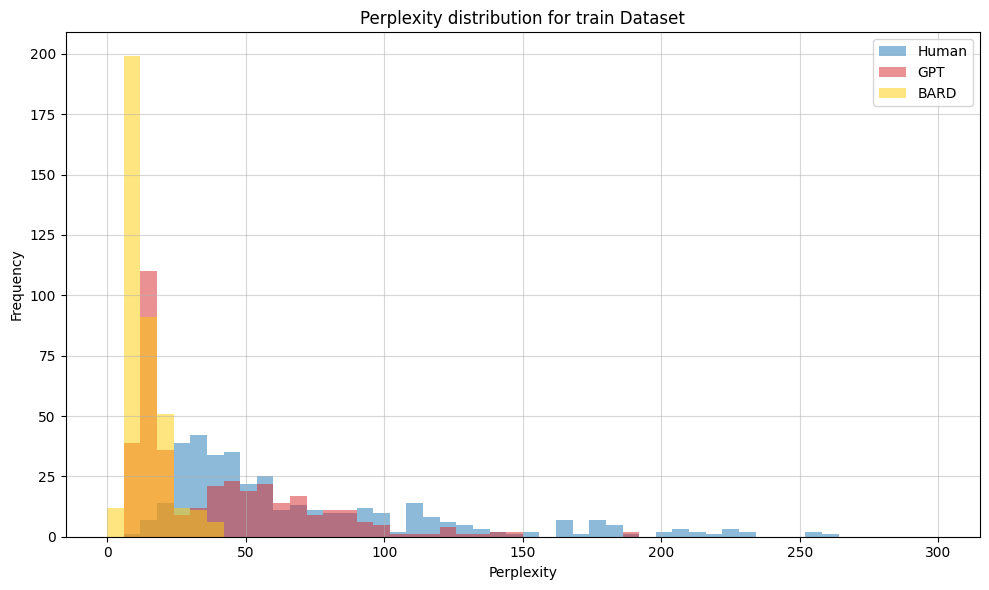

In [78]:
plot_histogram_perplexity_df(df_train)

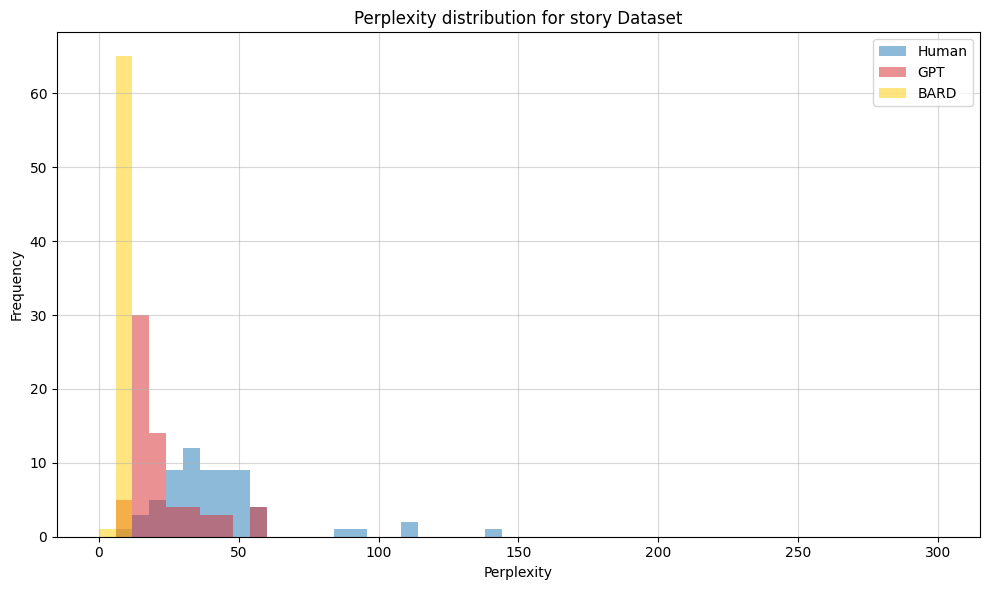

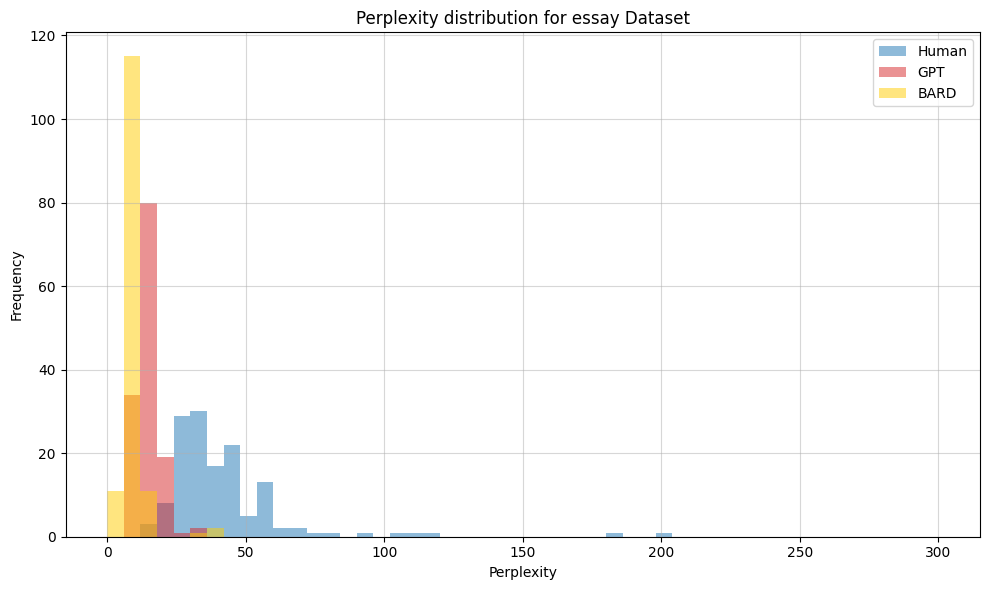

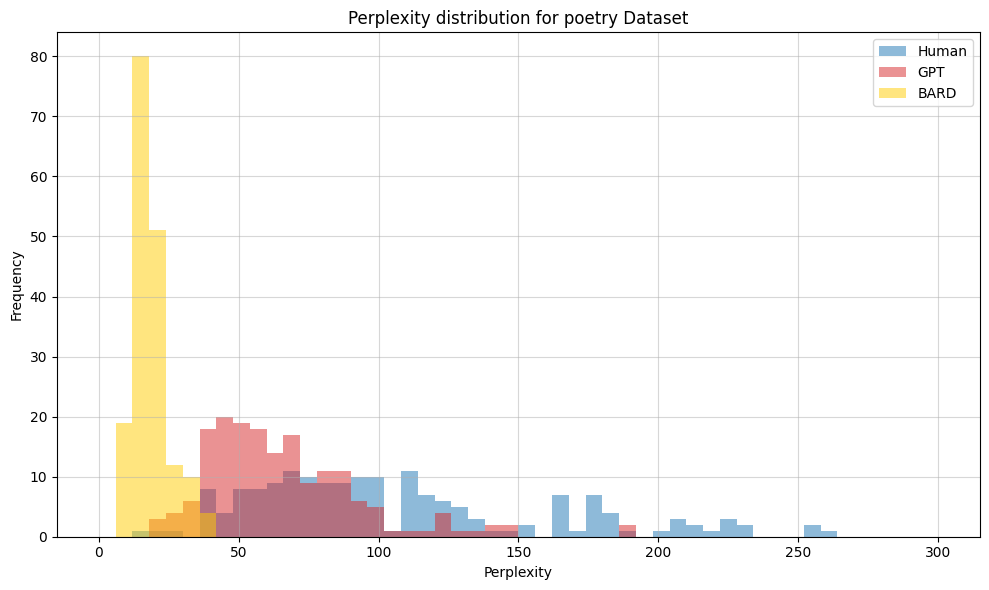

In [79]:
for data_type in ["story", "essay", "poetry"]:
    plot_histogram_perplexity_df(df_train[df_train.type==data_type], data_type=data_type)

In [80]:
def find_best_threshold(df_subset, thresholds=np.linspace(0, 300, 300)):
    best_f1 = 0
    best_threshold = None

    y_true = (df_subset["label"] == 2).astype(int)

    for t in thresholds:
        y_pred = (df_subset["perplexity"] <= t).astype(int)
        f1 = f1_score(y_true, y_pred, average="binary")
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = t

    return best_threshold, best_f1


In [70]:
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_on_test(df_test_subset, threshold, title=""):
    y_true = (df_test_subset["label"] == 2).astype(int)
    print(threshold)    
    y_pred = (df_test_subset["perplexity"] <= threshold).astype(int)

    f1 = f1_score(y_true, y_pred, average="macro")
    precision = precision_score(y_true, y_pred, average="macro")
    recall = recall_score(y_true, y_pred, average="macro")

    print(f"\n{title}")
    print(f"Threshold = {threshold:.2f}")
    print(f"F1 = {f1:.3f}, Precision = {precision:.3f}, Recall = {recall:.3f}")

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    labels = ["Human", "BARD"]
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix - {title}")
    plt.show()


12.040133779264213

Story (BARD vs Human)
Threshold = 12.04
F1 = 0.983, Precision = 0.983, Recall = 0.983


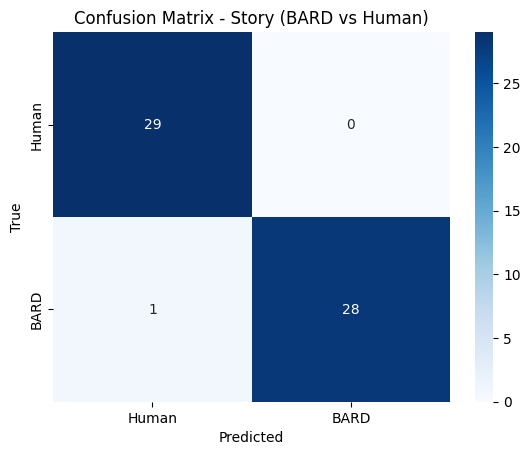

38.12709030100334

Poetry (BARD vs Human)
Threshold = 38.13
F1 = 0.960, Precision = 0.961, Recall = 0.961


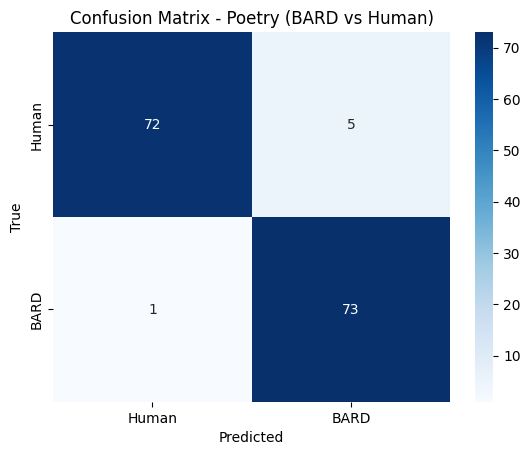

17.05685618729097

Essay (BARD vs Human)
Threshold = 17.06
F1 = 0.974, Precision = 0.976, Recall = 0.974


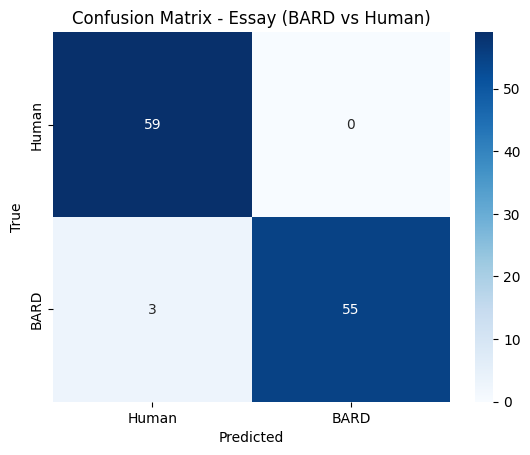

In [74]:
for data_type in ["story", "poetry", "essay"]:
    df_sub_train = df_train[(df_train["type"] == data_type) & (df_train["label"] != 1)]
    best_threshold, best_f1 = find_best_threshold(df_sub_train)
    df_sub_test = df_test[(df_test["type"] == data_type) & (df_test["label"] != 1)]
    evaluate_on_test(df_sub_test, best_threshold, title=f"{data_type.capitalize()} (BARD vs Human)")


### **BARD vs GPT**

In [75]:
def evaluate_on_test(df_test_subset, threshold, title=""):
    y_true = (df_test_subset["label"] == 2).astype(int)
    print(threshold)    
    y_pred = (df_test_subset["perplexity"] <= threshold).astype(int)

    f1 = f1_score(y_true, y_pred, average="macro")
    precision = precision_score(y_true, y_pred, average="macro")
    recall = recall_score(y_true, y_pred, average="macro")

    print(f"\n{title}")
    print(f"Threshold = {threshold:.2f}")
    print(f"F1 = {f1:.3f}, Precision = {precision:.3f}, Recall = {recall:.3f}")

    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    labels = ["GPT", "BARD"]
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix - {title}")
    plt.show()

12.040133779264213

Story (GPT vs BARD)
Threshold = 12.04
F1 = 0.965, Precision = 0.965, Recall = 0.965


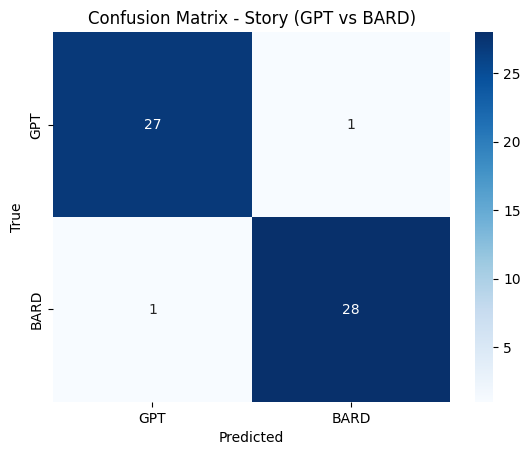

35.11705685618729

Poetry (GPT vs BARD)
Threshold = 35.12
F1 = 0.946, Precision = 0.947, Recall = 0.946


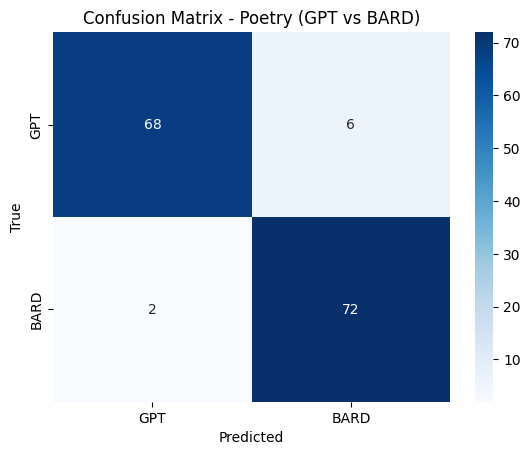

12.040133779264213

Essay (GPT vs BARD)
Threshold = 12.04
F1 = 0.790, Precision = 0.805, Recall = 0.795


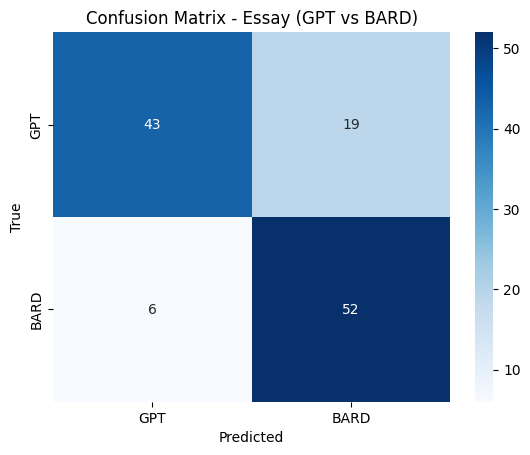

In [76]:
for data_type in ["story", "poetry", "essay"]:
    df_sub_train = df_train[(df_train["type"] == data_type) & (df_train["label"] != 0)]
    best_threshold, best_f1 = find_best_threshold(df_sub_train)
    df_sub_test = df_test[(df_test["type"] == data_type) & (df_test["label"] != 0)]
    evaluate_on_test(df_sub_test, best_threshold, title=f"{data_type.capitalize()} (GPT vs BARD)")